Some weights of CLIPModel were not initialized from the model checkpoint at chuhac/BiomedCLIP-vit-bert-hf and are newly initialized: ['text_model.final_layer_norm.bias', 'text_model.final_layer_norm.weight', 'text_projection.weight', 'vision_model.pre_layrnorm.bias', 'vision_model.pre_layrnorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


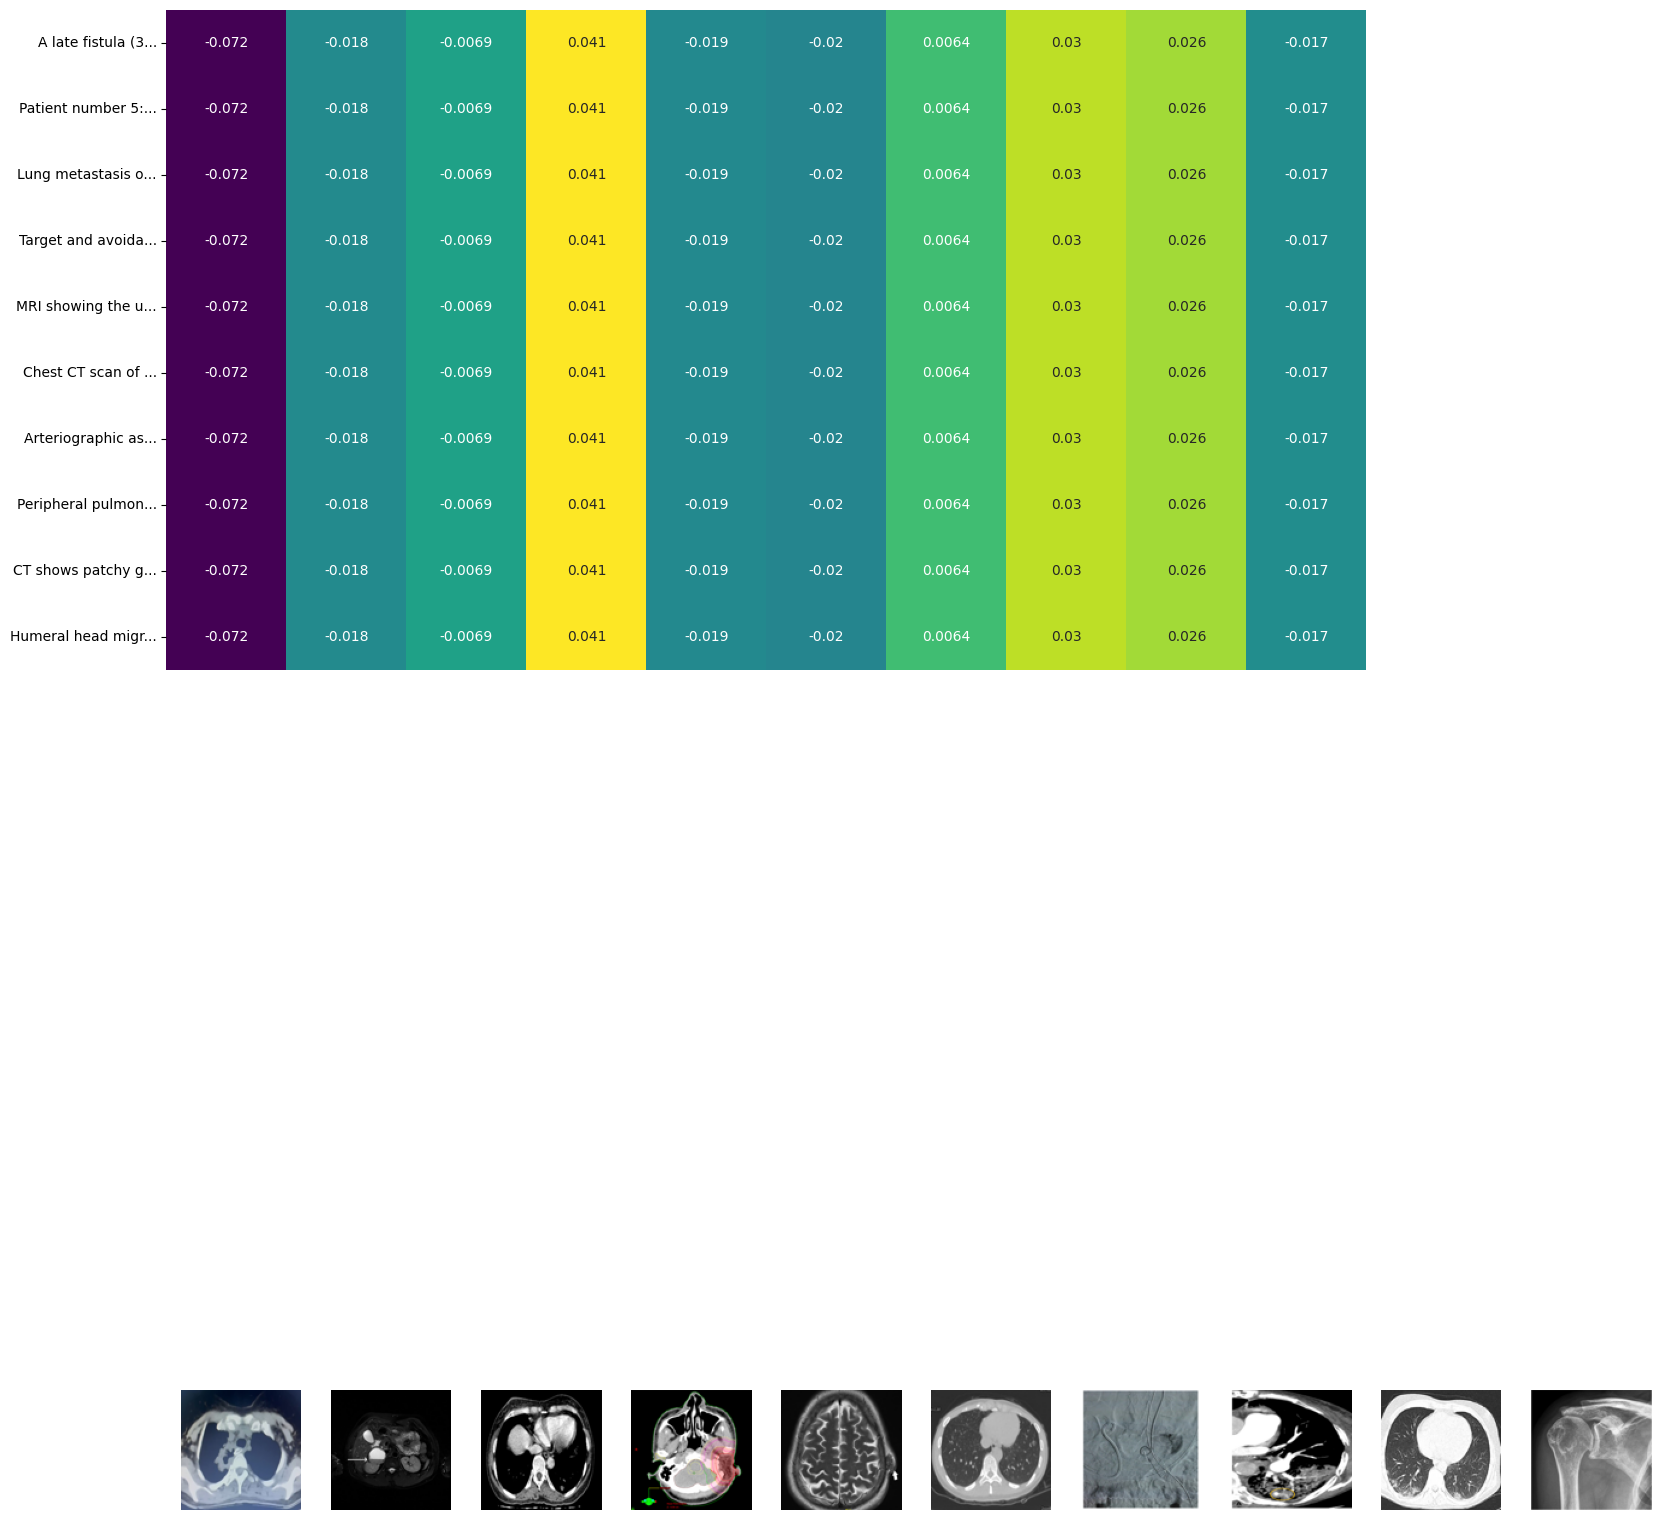

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Define the truncation function
def truncate_labels(labels, max_length):
    truncated_labels = []
    for label in labels:
        if len(label) > max_length:
            truncated_label = label[:max_length-3] + '...'
        else:
            truncated_label = label
        truncated_labels.append(truncated_label)
    return truncated_labels

# Load the dataset
file_path = "../Datasets/ROCO2/test_images/test/"
df = pd.read_csv("../Datasets/ROCO2/test_captions.csv", sep=',', header=1, names=['ID', 'Caption'])
df['Image'] = df['ID'] + ".jpg"
df.drop('ID', axis=1, inplace=True)

# Select 10 random samples
random_samples = df.sample(n=10, random_state=42)
captions = random_samples['Caption'].tolist()
image_paths = [os.path.join(file_path, img) for img in random_samples['Image'].tolist()]

# Load the BiomedCLIP model and processors
model_name = "chuhac/BiomedCLIP-vit-bert-hf"
model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image_input = clip_processor(images=image, return_tensors="pt")['pixel_values']
    with torch.no_grad():
        img_embeds = model.get_image_features(pixel_values=image_input)
    return img_embeds.cpu().numpy()

def get_text_embeddings(captions):
    all_text_embeds = []
    max_length = 77
    batch_size = 16
    truncated_captions = [caption[:max_length] for caption in captions]
    
    for i in range(0, len(truncated_captions), batch_size):
        batch_captions = truncated_captions[i:i+batch_size]
        text_inputs = bert_tokenizer(batch_captions, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        
        # Remove token_type_ids if present
        if 'token_type_ids' in text_inputs:
            text_inputs.pop('token_type_ids')
        
        with torch.no_grad():
            text_embeds = model.get_text_features(**text_inputs)
            all_text_embeds.append(text_embeds.cpu().numpy())
    
    all_text_embeds = np.vstack(all_text_embeds)
    return all_text_embeds

# Compute embeddings
image_embeddings = np.array([get_image_embedding(img_path) for img_path in image_paths])
text_embeddings = get_text_embeddings(captions)

# Compute cosine similarities
similarities = cosine_similarity(text_embeddings, image_embeddings.squeeze())

# Plot the heatmap with images and captions
fig, ax = plt.subplots(figsize=(15, 12))  # Increased figure size

# Define maximum length for truncation
max_label_length = 20

# Create heatmap
sns.heatmap(similarities, annot=True, cmap='viridis', ax=ax, cbar=False, xticklabels=False, yticklabels=captions)

# Truncate ytick labels
truncated_yticklabels = truncate_labels(captions, max_label_length)
ax.set_yticklabels(truncated_yticklabels, rotation=0)

# Add images below the heatmap using the specified extent
for idx, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((100, 100))  # Adjust size if needed
    img = np.array(img)

    # Position images below the heatmap
    imagebox = plt.axes([0.1 + idx * 0.1, -0.35, 0.1, 0.1], frameon=False)  # Adjust position if needed
    imagebox.imshow(img)
    imagebox.axis('off')

# Adjust plot layout
plt.subplots_adjust(left=0.1, bottom=0.35, right=0.9, top=0.9)
plt.xlabel('Images')
plt.ylabel('Captions')

plt.show()


In [19]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset('keremberke/chest-xray-classification','mini', split='test')

# Select 10 samples
images = [image for image in dataset['image'][:10]]
labels = dataset['labels'][:10]  # Correct column name is 'labels'

# Load the BiomedCLIP model and processors
model_name = "chuhac/BiomedCLIP-vit-bert-hf"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


# Preprocess images
inputs = processor(images=images, return_tensors="pt", padding=True)

# Get predictions
outputs = model(**inputs)
logits = outputs.logits_per_image.detach().numpy()

# Assuming labels are in text format, map them to indices
unique_labels = list(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
predictions = np.argmax(logits, axis=1)

# Create a DataFrame for the heatmap
df = pd.DataFrame(logits, columns=[f"Class {i}" for i in range(logits.shape[1])])
df['True Label'] = labels
df['Predicted Label'] = [unique_labels[pred] for pred in predictions]

# Convert to a format suitable for heatmap
heatmap_data = pd.crosstab(df['True Label'], df['Predicted Label'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix of 10 Sample Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Some weights of CLIPModel were not initialized from the model checkpoint at chuhac/BiomedCLIP-vit-bert-hf and are newly initialized: ['text_model.final_layer_norm.bias', 'text_model.final_layer_norm.weight', 'text_projection.weight', 'vision_model.pre_layrnorm.bias', 'vision_model.pre_layrnorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: You have to specify input_ids

In [22]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load the dataset
dataset = load_dataset('keremberke/chest-xray-classification', 'mini', split='test')

# Select 10 samples
images = [image for image in dataset['image'][:10]]
labels = dataset['labels'][:10]  # Correct column name is 'labels'

# Load the BiomedCLIP model and processor
model_name = "chuhac/BiomedCLIP-vit-bert-hf"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
tokenizer = CLIPTokenizer.from_pretrained(model_name)  # Ensure this is compatible

# Preprocess images
inputs = processor(images=images, return_tensors="pt", padding=True)

# Convert labels to text embeddings
text_inputs = tokenizer(labels, padding=True, return_tensors="pt", truncation=True)
text_embeddings = model.get_text_features(**text_inputs)

# Get image embeddings
with torch.no_grad():
    image_embeddings = model.get_image_features(**inputs)

# Calculate similarities between image embeddings and text embeddings
similarities = torch.matmul(image_embeddings, text_embeddings.T)
logits = similarities.numpy()

# Get predictions
predictions = np.argmax(logits, axis=1)

# Create a DataFrame for the heatmap
unique_labels = list(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

df = pd.DataFrame(logits, columns=[f"Class {i}" for i in range(logits.shape[1])])
df['True Label'] = labels
df['Predicted Label'] = [unique_labels[pred] for pred in predictions]

# Convert to a format suitable for heatmap
heatmap_data = pd.crosstab(df['True Label'], df['Predicted Label'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix of 10 Sample Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Some weights of CLIPModel were not initialized from the model checkpoint at chuhac/BiomedCLIP-vit-bert-hf and are newly initialized: ['text_model.final_layer_norm.bias', 'text_model.final_layer_norm.weight', 'text_projection.weight', 'vision_model.pre_layrnorm.bias', 'vision_model.pre_layrnorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CLIPTokenizerFast'.


ValueError: The `backend_tokenizer` provided does not match the expected format. The CLIP tokenizer has been heavily modified from transformers version 4.17.0. You need to convert the tokenizer you are using to be compatible with this version.The easiest way to do so is `CLIPTokenizerFast.from_pretrained("path_to_local_folder_or_hub_repo, from_slow=True)`. If you want to use your existing tokenizer, you will have to revert to a version prior to 4.17.0 of transformers.